In [1]:
from ast import literal_eval
from PIL import Image

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
text = "Caption: A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah."

def get_prompt(text):
    return f"""I will provide you with a caption for a photo , image , or painting . Your task is to generate the bounding boxes for the objects mentioned in the caption , along with a background prompt describing the scene . The images are of size 512 x512 , and the bounding boxes should not overlap or go beyond the image boundaries . Each bounding box should be in the format of ( object name , [ top - left x coordinate , top - left y coordinate , box width , box height ]) and include exactly one object . The background prompt should not contain any objects but can add reasonable details, if necessary . Please refer to the example below for the desired format .

    Caption: A realistic image of four skiers standi"ng in a line on the snow near a palm tree
    Objects: [('a skier', [5 , 152 , 139 , 168]) , ('a skier', [278 , 192 , 121 , 158]) , ('a skier', [148 , 173 , 124 , 155]) , ('a palm tree', [404 , 180 , 103 , 180])]
    Background prompt: A realistic image of an outdoor scene with snow

    Caption: Futuristic painting of a basketball player playing with a football in an indoor gym
    Objects: [('a basketball player', [40 , 152 , 156 , 241]) , ('a football', [237 , 17 , 54 , 32])]
    Background prompt: Futuristic painting of an indoor gym

    Caption: A pixelized image of a toy practicing his swordsmanship in a children's bedroom
    Objects: [('a toy', [34 , 145 , 120 , 237])]
    Background prompt: A pixelized image of a children's bedroom

    Caption: An oil painting of dog swimming in a blue lake towards a large branch
    Objects: [('a dog', [208 , 201 , 164 , 89]) , ('a large branch', [156 , 219 , 51 , 29])]
    Background prompt: An oil painting of a blue lake

    Caption: A low light image of a tractor in a field at sunset
    Objects: [ ('a tractor ', [246, 298, 165, 133]) ]
    Background prompt: A low light image of a field at sunset

    Caption: A surreal image of flower blooming in a pot
    Objects: [('flower', [215, 162, 123, 163]), ('a pot', [217, 411, 149, 90])]
    Background prompt:  A surreal image of the inside a house

    Caption: A watercolor painting of a couple of pandas eating bamboo in a forest
    Objects: [('a panda eating bamboo', [30, 133, 212, 226]), ('a panda eating bamboo', [262, 137, 222, 221])]
    Background prompt: A watercolor painting of a forest

    {text}"""

def get_short_prompt(text):
    return f"""I will provide you with a caption for a photo, image, or painting. Your task is to generate the bounding boxes for the objects mentioned in the caption. The images are of size 512x512, and the bounding boxes should not overlap or go beyond the image boundaries . Each bounding box should be in the format of ( object name , [ top - left x coordinate , top - left y coordinate , box width , box height ]) and include exactly one object . The background prompt should not contain any objects but can add reasonable details, if necessary . Please refer to the example below for the desired format .

    Caption: A realistic image of four skiers standi"ng in a line on the snow near a palm tree
    Objects: [('a skier', [5 , 152 , 139 , 168]) , ('a skier', [278 , 192 , 121 , 158]) , ('a skier', [148 , 173 , 124 , 155]) , ('a palm tree', [404 , 180 , 103 , 180])]
    Background prompt: A realistic image of an outdoor scene with snow

    Caption: Futuristic painting of a basketball player playing with a football in an indoor gym
    Objects: [('a basketball player', [40 , 152 , 156 , 241]) , ('a football', [237 , 17 , 54 , 32])]
    Background prompt: Futuristic painting of an indoor gym

    Caption: A pixelized image of a toy practicing his swordsmanship in a children's bedroom
    Objects: [('a toy', [34 , 145 , 120 , 237])]
    Background prompt: A pixelized image of a children's bedroom

    {text}"""

In [4]:
def parse_objects(output_str):
    output_parts = output_str.split("\n")
    objects = literal_eval(output_parts[1].strip()[len("Objects:"):].strip())
    return objects

In [5]:
def plot_bboxes(objects, type="xywh", multiplier=1):
    im = Image.fromarray(np.ones((512, 512, 3), np.uint8)*255)
    fig, ax = plt.subplots()
    ax.imshow(im)

    for i, obj in enumerate(objects):
        print(obj)
        label = obj[0]
        try:
            x, y, w, h = [val * multiplier for val in obj[1]]
        except:
            x, y, w, h = [val * multiplier for val in literal_eval(obj[1])]

        if type == "xyxy":
            w -= x
            h -= y

        # add bounding boxes to the image
        box = patches.Rectangle(
            (x, y), w, h, edgecolor="red", facecolor="none"
        )

        ax.add_patch(box)

        rx, ry = box.get_xy()
        cx = rx + box.get_width()/2.0
        cy = ry + box.get_height()/8.0
        l = ax.annotate(
            label,
            (cx, cy),
            fontsize=8,
            fontweight="bold",
            color="white",
            ha='center',
            va='center'
        )
        l.set_bbox(
            dict(facecolor='red', alpha=0.5, edgecolor='red')
        )

    plt.show()

### Finetuned GPT2-large

In [6]:
%%capture

tokenizer = AutoTokenized.from_pretrained('gpt2-large')
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("checkpoints_large/checkpoint2.pt/").to(device)
model.eval()

In [9]:
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 
Objects: [('a cheetah', [3, 103, 223, 389]), ('two zebras', [2, 159, 509, 352]), ('two zebras', [179, 159, 213, 349])]


('a cheetah', [3, 103, 223, 389])
('two zebras', [2, 159, 509, 352])
('two zebras', [179, 159, 213, 349])


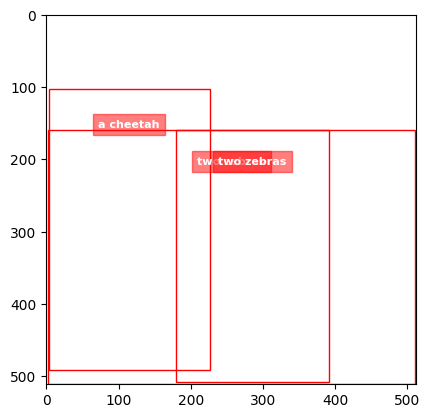

In [10]:
objects = parse_objects(output_str)
plot_bboxes(objects)

In-context examples

In [11]:
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('a cheetah', [2, 2, 246, 380]), ('two zebras', [2, 129, 441, 385])]


('a cheetah', [2, 2, 246, 380])
('two zebras', [2, 129, 441, 385])


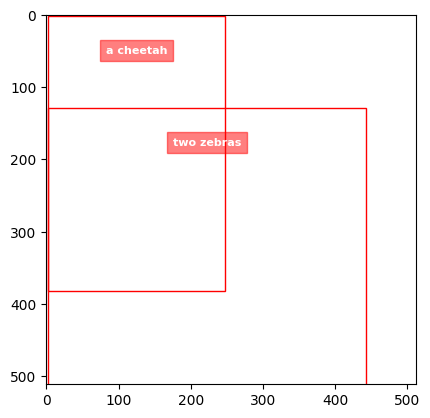

In [12]:
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    Objects: [('a man', [2, 3, 223, 509]), ('his dog', [236, 169, 95, 191]), ('a frisbee', [235, 217, 43, 37])]
('a man', [2, 3, 223, 509])
('his dog', [236, 169, 95, 191])
('a frisbee', [235, 217, 43, 37])


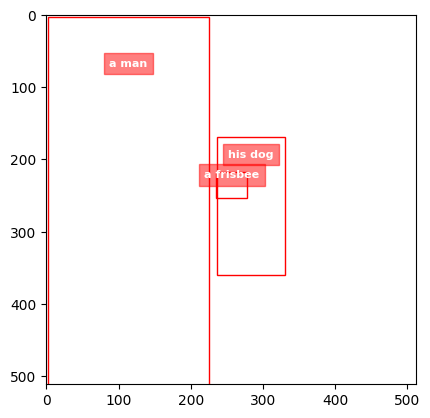

In [13]:
text = "Caption: A man and his dog playing with a frisbee in the hills"
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 in a room. 
Objects: [('4 jugglers', [236, 137, 92, 229]), ('4 jugglers', [201, 146, 59, 219]), ('a room', [2, 3, 509, 509]), ('4 bowling pins', [193, 231, 22, 25])]
('4 jugglers', [236, 137, 92, 229])
('4 jugglers', [201, 146, 59, 219])
('a room', [2, 3, 509, 509])
('4 bowling pins', [193, 231, 22, 25])


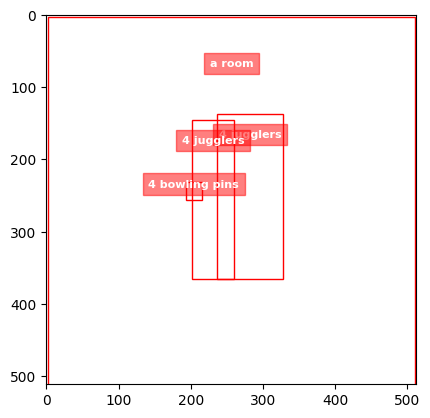

In [15]:
text = "Caption: 4 jugglers juggling 4 bowling pins"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. 
Objects: [('a realistic camera', [119, 148, 98, 166]), ('a video game arcade', [2, 3, 509, 508])]
('a realistic camera', [119, 148, 98, 166])
('a video game arcade', [2, 3, 509, 508])


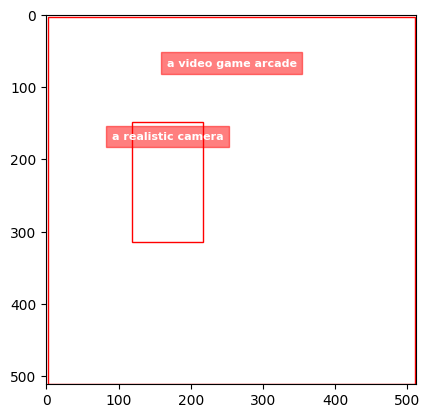

In [16]:
text = "Caption: A realistic camera shot a video game arcade at night"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


. 
Objects: [('a pond', [3, 289, 508, 222]), ('an oil painting', [3, 3, 508, 507]), ('of flowers', [2, 3, 508, 507])]
('a pond', [3, 289, 508, 222])
('an oil painting', [3, 3, 508, 507])
('of flowers', [2, 3, 508, 507])


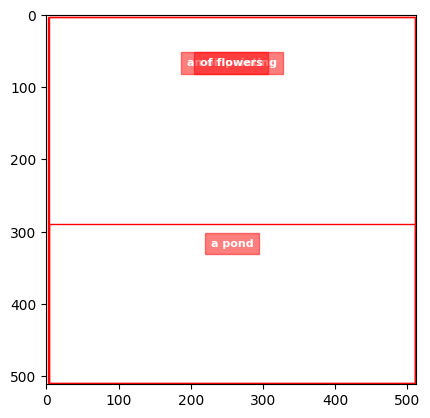

In [18]:
text = "Caption: An oil painting of 3 varieties of flowers blooming next to a pond"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

### [MPT-1B-redpajama-200b-dolly](https://huggingface.co/mosaicml/mpt-1b-redpajama-200b-dolly)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("mosaicml/mpt-1b-redpajama-200b-dolly", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("mosaicml/mpt-1b-redpajama-200b-dolly", trust_remote_code=True).to(device)

C:\Users\Shivaen/.cache\huggingface\modules\transformers_modules\mosaicml\mpt-1b-redpajama-200b-dolly\d3586068c3d023c7fcfa3c7dbd3042b2f00db1e3\attention.py:289: UserWarning: Using `attn_impl: torch`. If your model does not use `alibi` or `prefix_lm` we recommend using `attn_impl: flash` otherwise we recommend using `attn_impl: triton`.
  warnings.warn(


You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


In [9]:
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)


Objects : [ ('a cheetah ', [156, 217, 51, 29]), ('a zebra ', [205, 137, 227, 227]) ]
Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A high contrast image of a skier standing in a line on the snow near a palm tree
Objects : [ ('a skier ', [5, 152, 139, 168]), ('a skier ', [278, 192, 121, 158]), ('a skier ', [148, 173, 124, 155]), ('


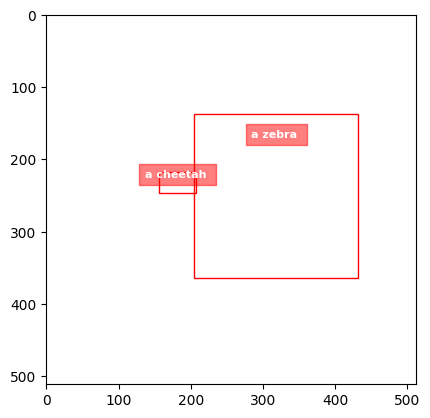

In [14]:
objects = parse_objects(output_str)
plot_bboxes(objects)

### [RedPajama-INCITE-Instruct-3B-v1](https://huggingface.co/togethercomputer/RedPajama-INCITE-Instruct-3B-v1)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Instruct-3B-v1")
model = AutoModelForCausalLM.from_pretrained("shivr/RedPajama-INCITE-Instruct-3B-v1-layout", torch_dtype=torch.float16)
model = model.to('cuda:0')

c:\Users\Shivaen\anaconda3\envs\LayoutSD\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shivaen\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


. 
Objects: [('a man', [161, 7, 354, 928]), ('a dog', [2, 7, 352, 831])]
('a man', [161, 7, 354, 928])
('a dog', [2, 7, 352, 831])


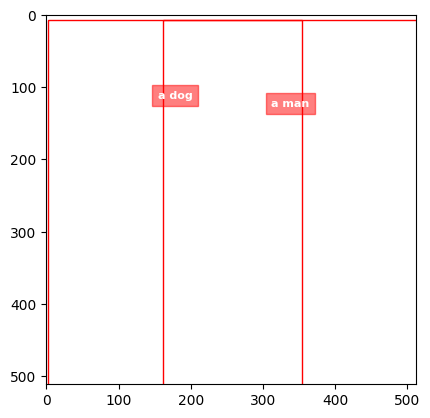

In [33]:
text = "Caption: A man and his dog playing with a frisbee in the hills"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

In-context examples

In [19]:
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Objects: [('two zebras', [6, 182, 207, 208]), ('a cheetah', [37, 21, 222, 36])]
Background prompt: A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption: A man standing on top of a snow covered mountain with a snowboard in his hand. 
Objects: [('a snow covered mountain', [2, 2, 202, 205]), ('a snowboard', [1, 93, 127, 52])]
Background prompt: A man standing on top of a snow


('two zebras', [6, 182, 207, 208])
('a cheetah', [37, 21, 222, 36])


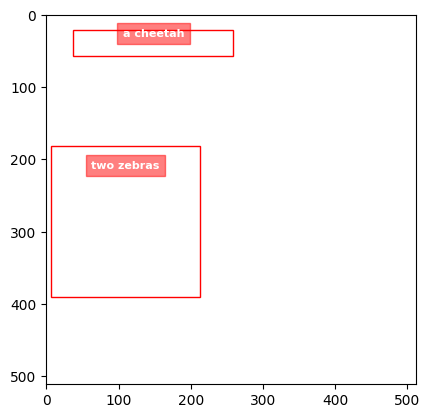

In [20]:
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



    Objects: [('a man', [178, 165, 163, 169]), ('a dog', [239, 141, 170, 169])]
    Background prompt: A man and his dog playing with a frisbee in the hills

    Caption: A red fire hydrant sitting next to a street sign
    Objects: [('a red fire hydrant', [24, 232, 54, 65]), ('a street sign', [254, 36, 60, 59])]
    Background prompt: A red fire hydrant sitting next to a street sign

    Caption: A blue and white
('a man', [178, 165, 163, 169])
('a dog', [239, 141, 170, 169])


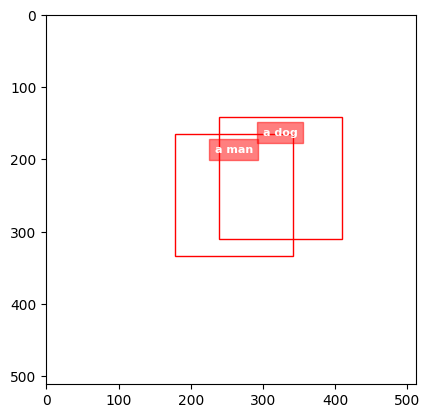

In [35]:
text = "Caption: A man and his dog playing with a frisbee in the hills"
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


. 
Objects: [('juggler', [5, 4, 3, 2]), ('bowling pin', [2, 2, 1, 1])]
('juggler', [5, 4, 3, 2])
('bowling pin', [2, 2, 1, 1])


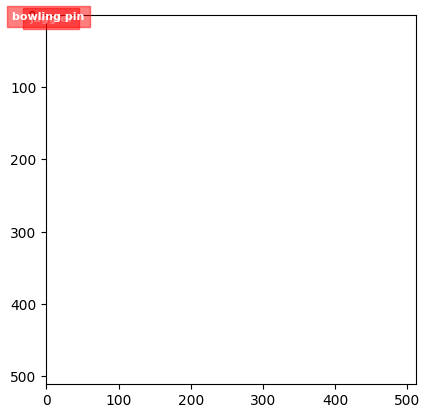

In [39]:
text = "Caption: 4 jugglers juggling 4 bowling pins"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


. 
Objects: [('a video game arcade', [102, 116, 205, 169])]
('a video game arcade', [102, 116, 205, 169])


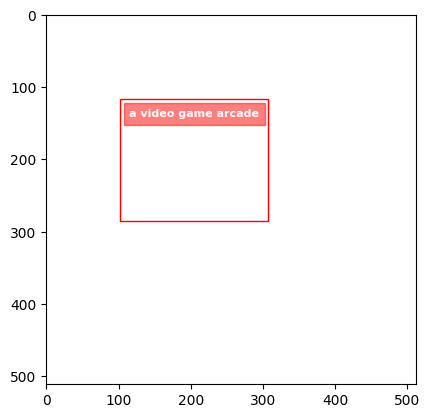

In [41]:
text = "Caption: A realistic camera shot a video game arcade at night"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


. 
Objects: [('an oil painting', [7, 3, 502, 506]), ('3 varieties of flowers', [2, 406, 899, 793]), ('a pond', [1, 4, 936, 723])]
('an oil painting', [7, 3, 502, 506])
('3 varieties of flowers', [2, 406, 899, 793])
('a pond', [1, 4, 936, 723])


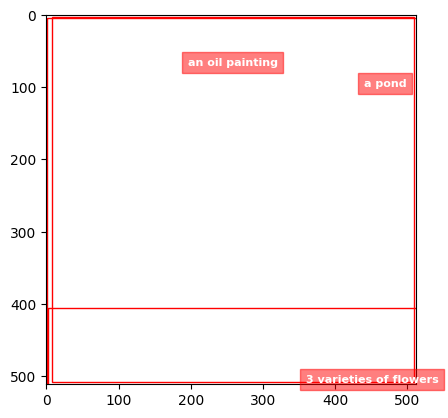

In [47]:
text = "Caption: An oil painting of 3 varieties of flowers blooming next to a pond"
inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:-1]
output_str = tokenizer.decode(token)
print(output_str)
objects = parse_objects(output_str)
plot_bboxes(objects)

### [RedPajama-INCITE-7B-Instruct](https://huggingface.co/togethercomputer/RedPajama-INCITE-7B-Instruct)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-7B-Instruct")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-7B-Instruct", torch_dtype=torch.float16)
model = model.to('cuda:0')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
inputs = tokenizer(get_prompt(text), return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.



Objects : [ ('a cheetah ', [32, 30, 200, 224]), ('two zebras ', [208, 224, 168, 198]) ]
Background prompt : A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah

Caption : A photo of a woman on a tennis court with a tennis racket
Objects : [ ('a tennis racket ', [46, 224, 54, 216]), ('a tennis player ', [64, 216, 144, 240]), ('a tennis court ', [224, 96, 96, 96]) ]
Background prompt : A


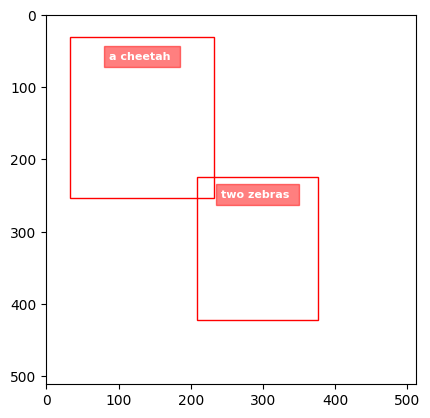

In [8]:
objects = parse_objects(output_str)
plot_bboxes(objects)

## Finetune on Local Narratives

### [GPT2-xl](https://huggingface.co/shivr/gpt2-xl_local-narratives_pre)

In [6]:
%%capture

tokenizer = AutoTokenizer.from_pretrained('gpt2-xl')
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("shivr/gpt2-xl_local-narratives_pre").to(device)
model.eval()

In [15]:
text = "Caption: A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('a cheetah', [2, 68, 509, 442]), ('a fantasy', [2, 3, 509, 506]), ('zebras', [2, 3, 509, 506]), ('zebras', [249, 5, 261, 505])]



('a cheetah', [2, 68, 509, 442])
('a fantasy', [2, 3, 509, 506])
('zebras', [2, 3, 509, 506])
('zebras', [249, 5, 261, 505])


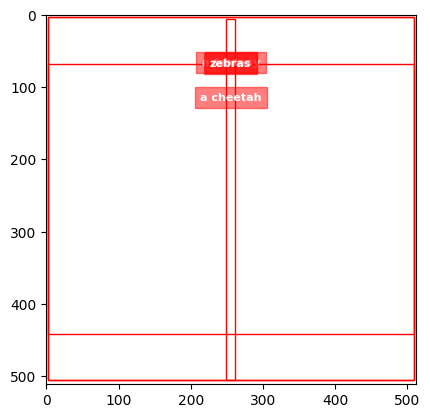

In [16]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy")

In [21]:
text = "Caption: A man and his dog playing with a frisbee in the hills."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('a dog', [334, 3, 178, 509]), ('a man', [133, 3, 378, 509]), ('a frisbee', [3, 75, 277, 435])]



('a dog', [334, 3, 178, 509])
('a man', [133, 3, 378, 509])
('a frisbee', [3, 75, 277, 435])


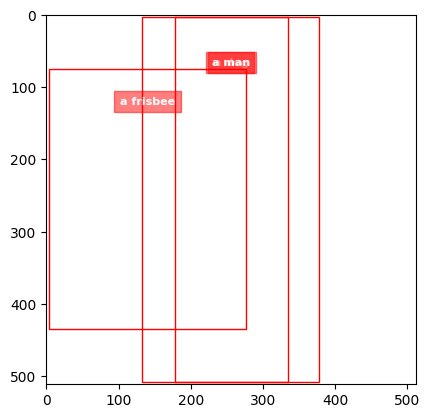

In [22]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy")

In [35]:
text = "Caption: An oil painting of 3 varieties of flowers blooming next to a pond."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('an oil painting', [2, 3, 509, 508]), ('various', [2, 3, 509, 508]), ('flowers', [2, 3, 509, 508]), ('a pond', [2, 154, 509, 357]), ('flowers', [2, 240, 509, 271]), ('flowers', [3, 3, 508, 508])]



('an oil painting', [2, 3, 509, 508])
('various', [2, 3, 509, 508])
('flowers', [2, 3, 509, 508])
('a pond', [2, 154, 509, 357])
('flowers', [2, 240, 509, 271])
('flowers', [3, 3, 508, 508])


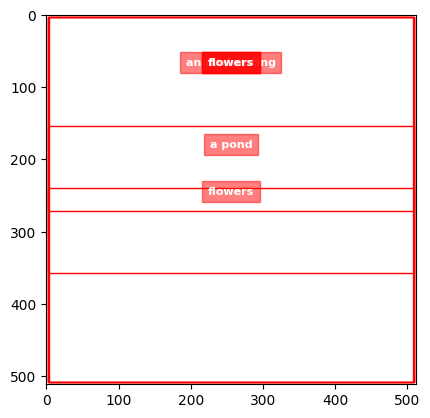

In [36]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy")

### [GPT2-large](https://huggingface.co/shivr/gpt2-large_local-narratives_pre)

In [6]:
%%capture
tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("shivr/gpt2-large_local-narratives_pre").to(device)
model.eval()

In [14]:
text = "Caption: A fantasy styled overhead shot of two zebras running from a cheetah in the African savannah."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('a cheetah', [0.0, 0.06, 0.3, 0.61]), ('zebras', [0.41, 0.37, 0.29, 0.53]), ('zebras', [0.22, 0.37, 0.21, 0.53]), ('the African savannah', [0.0, 0.01, 0.99, 0.99])]


('a cheetah', [0.0, 0.06, 0.3, 0.61])
('zebras', [0.41, 0.37, 0.29, 0.53])
('zebras', [0.22, 0.37, 0.21, 0.53])
('the African savannah', [0.0, 0.01, 0.99, 0.99])


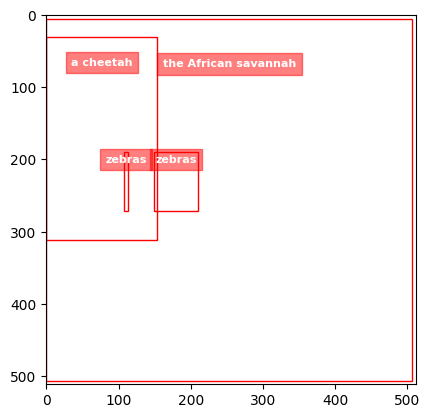

In [15]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy", multiplier=512)

In [23]:
text = "Caption: A man and his dog playing with a frisbee in the hills."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('a man', [0.21, 0.24, 0.37, 0.76]), ('his dog', [0.33, 0.46, 0.19, 0.54]), ('a frisbee', [0.06, 0.43, 0.11, 0.07]), ('the hills', [0.0, 0.01, 0.99, 0.99])]


('a man', [0.21, 0.24, 0.37, 0.76])
('his dog', [0.33, 0.46, 0.19, 0.54])
('a frisbee', [0.06, 0.43, 0.11, 0.07])
('the hills', [0.0, 0.01, 0.99, 0.99])


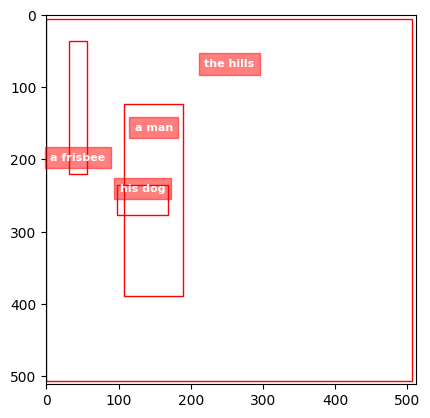

In [24]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy", multiplier=512)

In [42]:
text = "Caption: An oil painting of 3 varieties of flowers blooming next to a pond."

inputs = tokenizer(text, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.3, top_p=0.7, top_k=100, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token[:-1])
print(output_str)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Objects: [('flowers', [0.01, 0.01, 0.99, 0.99]), ('flowers', [0.37, 0.01, 0.62, 0.99]), ('flowers', [0.01, 0.01, 0.99, 0.99]), ('a pond', [0.01, 0.01, 0.99, 0.99])]


('flowers', [0.01, 0.01, 0.99, 0.99])
('flowers', [0.37, 0.01, 0.62, 0.99])
('flowers', [0.01, 0.01, 0.99, 0.99])
('a pond', [0.01, 0.01, 0.99, 0.99])


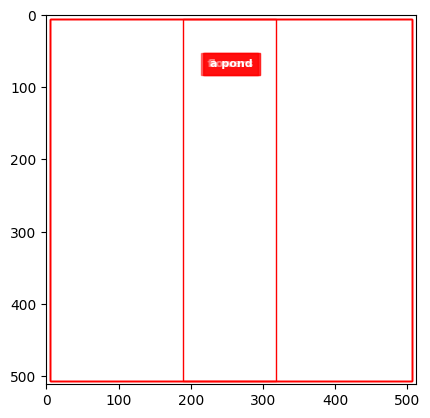

In [43]:
objects = parse_objects(output_str)
plot_bboxes(objects, type="xyxy", multiplier=512)